In [1]:
# File Handling & Data Manipulation
import os
import shutil
import pandas as pd
import numpy as np
import random

# Define Variables
SEED = 42
BATCH_SIZE = 64

# Path ke folder dataset animals10
# Misal, jika Anda menjalankan di local atau colab, sesuaikan path berikut:
data_dir = "/kaggle/input/animals10/raw-img"  # Ganti sesuai lokasi dataset Anda

# Mendapatkan daftar kelas (nama folder)
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
print("Kelas yang ditemukan:", class_names)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Image Processing
import cv2
from PIL import Image, UnidentifiedImageError
from torchvision.transforms.functional import to_pil_image

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Pretrained Models
from torchvision import transforms
from torchvision import models

# Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score

# Warning
import warnings
warnings.filterwarnings('ignore')

# Define the rc parameters
rc_params = {
    "axes.facecolor": "#FFFFFF",
    "figure.facecolor": "#FFFFFF",
    "grid.color": "#FFFFFF",
    "grid.alpha": 0.4
}

# Update matplotlib's rcParams
plt.rcParams.update(rc_params)
cmap = sns.diverging_palette(220, 20, as_cmap=True)

Kelas yang ditemukan: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [2]:
def set_seed_project(random_state=SEED): 
    """
    Set seed for reproducibility.

    Args:
        random_state (int): Seed number, SEED (42) by default.
    """

    # Set seed for Python's random module
    random.seed(random_state)
    
    # Set seed for NumPy
    np.random.seed(random_state)
    
    # Set seed for PyTorch
    torch.manual_seed(random_state)
    
    # Set seed for CuDNN backend for GPU determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Set seed for PyTorch GPU if available
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)

set_seed_project()

In [3]:
def load_dataset_df(img_dir):
    classes = sorted([d for d in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, d))])
    data = []
    for cls in classes:
        cls_dir = os.path.join(img_dir, cls)
        for img_name in os.listdir(cls_dir):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(cls_dir, img_name)
                data.append((img_path, cls))  # img_path dan label
    df = pd.DataFrame(data, columns=["img_path", "label"])
    return df

# Load the dataset (semua data)
df = load_dataset_df(data_dir)

# Mapper Italia ke Indonesia
italian_to_indonesian = {
    "cane": "anjing",
    "cavallo": "kuda",
    "elefante": "gajah",
    "farfalla": "kupu-kupu",
    "gallina": "ayam",
    "gatto": "kucing",
    "mucca": "sapi",
    "pecora": "domba",
    "ragno": "laba-laba",
    "scoiattolo": "tupai"
}

# Terapkan mapping ke kolom label
df['label'] = df['label'].map(italian_to_indonesian)

# Buat mapping label ke index GLOBAL (dari label Indonesia)
label_list = sorted(df['label'].unique())
label2idx = {label: idx for idx, label in enumerate(label_list)}
idx2label = {idx: label for label, idx in label2idx.items()}

print("Jumlah data total:", len(df))
print("Contoh mapping label:", label2idx)
print("Contoh 5 data:")
print(df.sample(5))

Jumlah data total: 26179
Contoh mapping label: {'anjing': 0, 'ayam': 1, 'domba': 2, 'gajah': 3, 'kucing': 4, 'kuda': 5, 'kupu-kupu': 6, 'laba-laba': 7, 'sapi': 8, 'tupai': 9}
Contoh 5 data:
                                                img_path   label
1968   /kaggle/input/animals10/raw-img/cane/OIP-DUmvg...  anjing
17679  /kaggle/input/animals10/raw-img/pecora/OIP-IkT...   domba
5923   /kaggle/input/animals10/raw-img/cavallo/OIP-Ab...    kuda
1087   /kaggle/input/animals10/raw-img/cane/OIP-Qk5mS...  anjing
7172   /kaggle/input/animals10/raw-img/cavallo/OIP-Kq...    kuda


In [4]:
df.head()

img_path   label
0  /kaggle/input/animals10/raw-img/cane/OIP-6p-HH...  anjing
1  /kaggle/input/animals10/raw-img/cane/OIP-A1GkR...  anjing
2  /kaggle/input/animals10/raw-img/cane/OIP-GZmwq...  anjing
3  /kaggle/input/animals10/raw-img/cane/OIP-Yj0uE...  anjing
4  /kaggle/input/animals10/raw-img/cane/OIP-bbrbp...  anjing

In [5]:
# Value counts of labels
value_counts = df['label'].value_counts()
value_counts

label
anjing       4863
laba-laba    4821
ayam         3098
kuda         2623
kupu-kupu    2112
sapi         1866
tupai        1862
domba        1820
kucing       1668
gajah        1446
Name: count, dtype: int64

Gambar hasil plot disimpan di: animal_samples.png


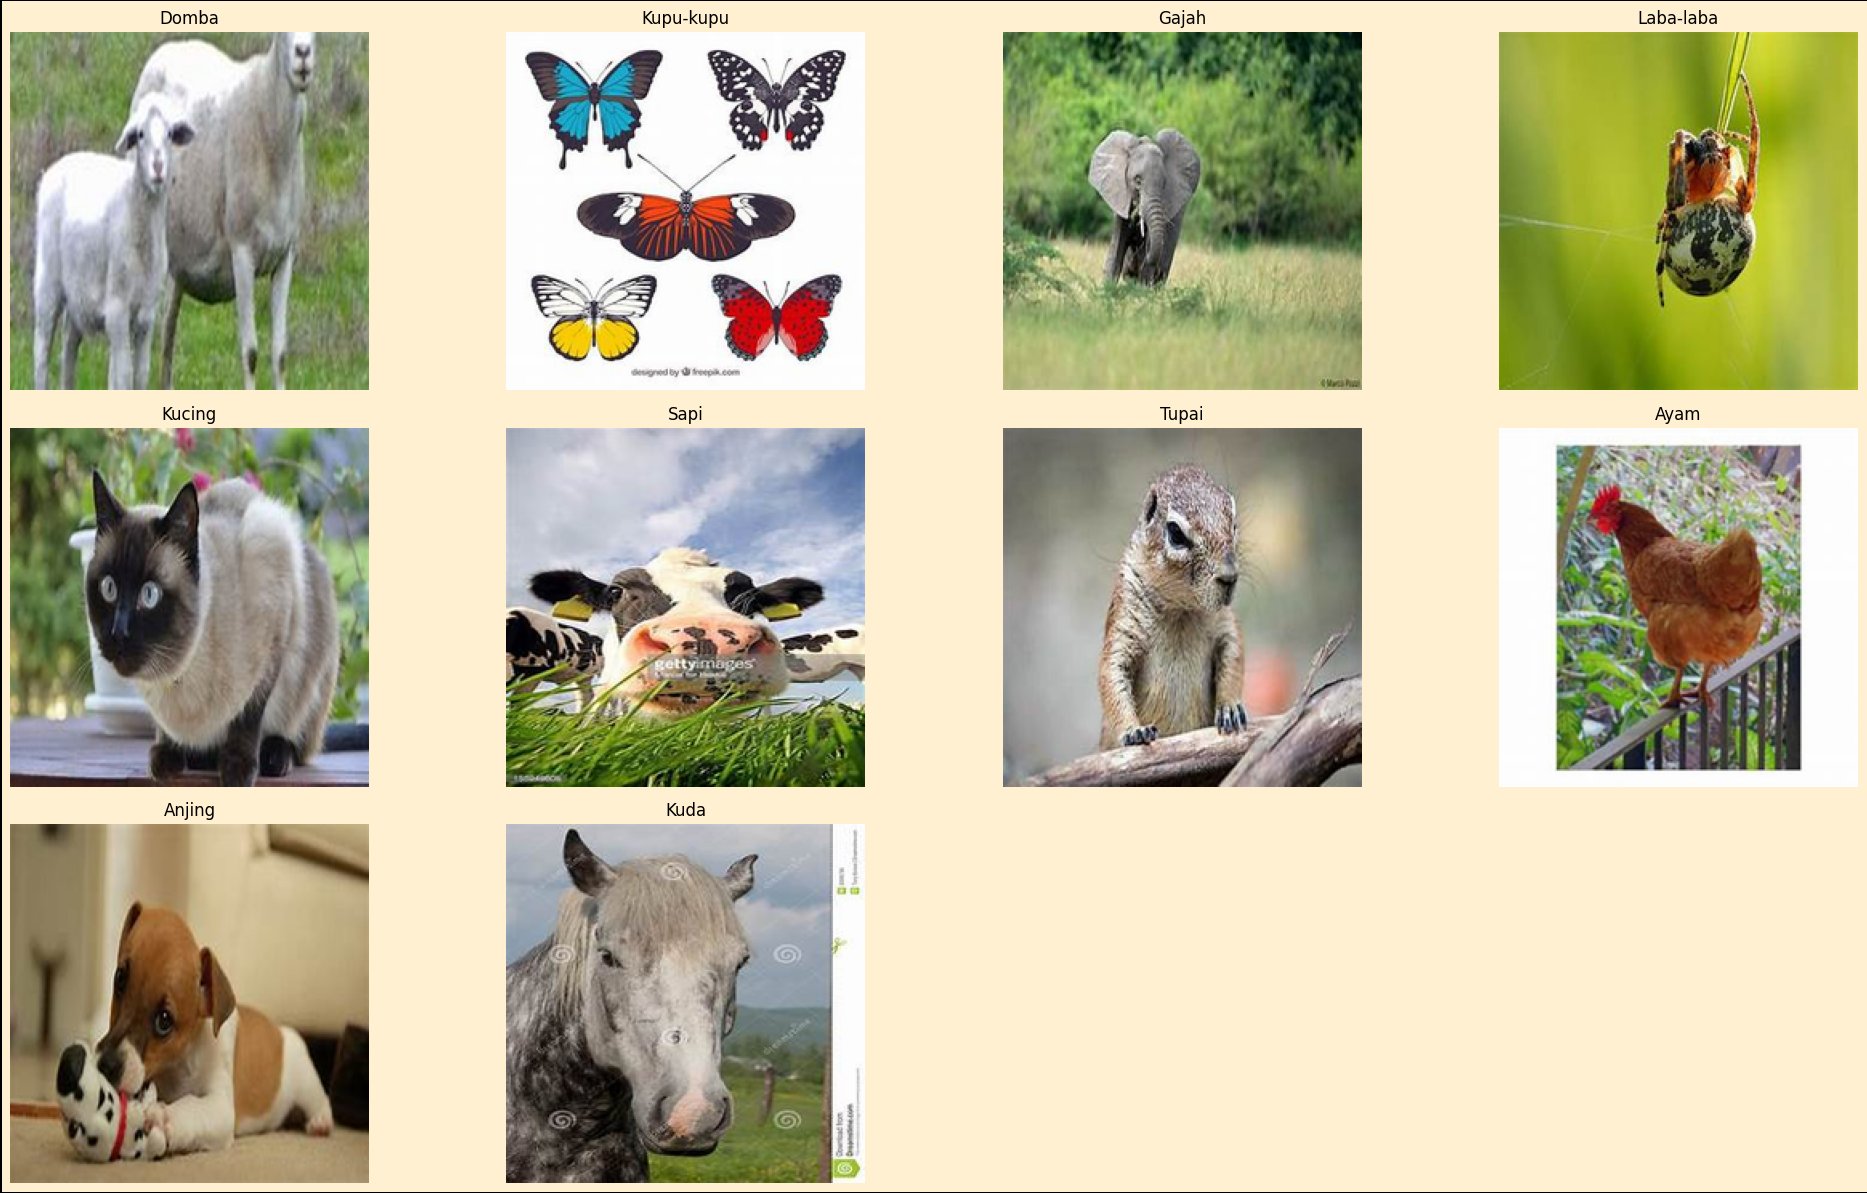

In [6]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Mapping label Italia ke Indonesia
italian_to_indonesian = {
    "cane": "anjing",
    "cavallo": "kuda",
    "elefante": "gajah",
    "farfalla": "kupu-kupu",
    "gallina": "ayam",
    "gatto": "kucing",
    "mucca": "sapi",
    "pecora": "domba",
    "ragno": "laba-laba",
    "scoiattolo": "tupai"
}

def show_animal_samples(root_dir, rows=4, cols=4, save_path=None, img_size=224):
    """
    Menampilkan dan/atau menyimpan contoh gambar hewan dari dataset Animals10
    dengan label dalam Bahasa Indonesia dan ukuran gambar seragam.

    Args:
        root_dir (str): Direktori root dataset.
        rows (int): Jumlah baris subplot.
        cols (int): Jumlah kolom subplot.
        save_path (str, optional): Path file untuk menyimpan gambar hasil plot.
        img_size (int): Ukuran gambar (lebar dan tinggi) setelah resize.
    """
    fig, axes = plt.subplots(
        rows, cols, figsize=(5 * cols, 4 * rows), facecolor='#fff0d1'
    )
    fig.patch.set_linewidth(2)
    fig.patch.set_edgecolor('black')

    # Ambil semua kategori (label)
    categories = sorted([
        d for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d))
    ])
    random.shuffle(categories)

    for idx, category in enumerate(categories[:rows * cols]):
        category_path = os.path.join(root_dir, category)
        if os.path.isdir(category_path):
            images = [
                img for img in os.listdir(category_path)
                if img.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]
            if images:
                random_img = random.choice(images)
                img_path = os.path.join(category_path, random_img)
                img = Image.open(img_path).convert("RGB")
                img = img.resize((img_size, img_size), Image.LANCZOS)
                axes[idx // cols, idx % cols].imshow(img)
                axes[idx // cols, idx % cols].axis('off')

                # Ubah label ke Bahasa Indonesia jika ada di mapping
                label_indo = italian_to_indonesian.get(category, category)
                axes[idx // cols, idx % cols].set_title(
                    label_indo.capitalize(), fontsize=12
                )

    # Sembunyikan subplot yang tidak terpakai
    for i in range(len(categories), rows * cols):
        axes[i // cols, i % cols].axis('off')
        axes[i // cols, i % cols].set_visible(False)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=200)
        print(f"Gambar hasil plot disimpan di: {save_path}")
    plt.show()

# Contoh pemanggilan fungsi dengan resize gambar ke 224x224 dan simpan ke file
show_animal_samples(root_dir=data_dir, rows=4, cols=4, save_path="animal_samples.png", img_size=224)

In [7]:
# Initialize the image transformations with data augmentation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)), 
    # transforms.RandomResizedCrop(224),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(15),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
class AnimalDataset(Dataset):
    def __init__(self, dataframe, label2idx, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.label2idx = label2idx
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        label_idx = self.label2idx[label]
        try:
            image = Image.open(img_path).convert("RGB")
        except (FileNotFoundError, UnidentifiedImageError) as e:
            print(f"Error loading {img_path}: {e}")
            return torch.zeros((3, 224, 224)), label_idx, img_path  # <-- tambahkan img_path
        if self.transform:
            image = self.transform(image)
        return image, label_idx, img_path  # <-- tambahkan img_path

In [9]:
from torch.utils.data import random_split, DataLoader

# Buat dataset dari seluruh data
full_dataset = AnimalDataset(dataframe=df, label2idx=label2idx, transform=transform_train)

# Tentukan proporsi split (misal 80% train, 20% test)
total_size = len(full_dataset)
test_size = int(0.2 * total_size)
train_size = total_size - test_size

# Random split
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(SEED))

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print the dataset size
print("Jumlah data training:", len(train_dataset))
print("Jumlah data testing:", len(test_dataset))

# Check the first batch of training data
for images, labels, img_paths in train_loader:
    print("Batch images shape:", images.shape)  # (batch_size, 3, 224, 224)
    print("Batch labels:", labels)              # Sudah berupa index
    break

# Check the first batch of testing data
for images, labels, img_paths in test_loader:
    print("Batch images shape:", images.shape)  # (batch_size, 3, 224, 224)
    print("Batch labels:", labels)              # Sudah berupa index
    break

Jumlah data training: 20944
Jumlah data testing: 5235
Batch images shape: torch.Size([64, 3, 224, 224])
Batch labels: tensor([6, 0, 6, 6, 0, 0, 3, 7, 1, 7, 5, 1, 2, 9, 3, 0, 0, 9, 1, 8, 3, 6, 7, 5,
        1, 4, 7, 4, 7, 0, 3, 5, 1, 0, 0, 0, 0, 0, 6, 0, 6, 4, 7, 0, 0, 5, 0, 2,
        8, 8, 0, 1, 0, 3, 0, 7, 7, 6, 2, 0, 5, 8, 6, 7])
Batch images shape: torch.Size([64, 3, 224, 224])
Batch labels: tensor([7, 5, 4, 5, 1, 2, 2, 5, 8, 0, 5, 1, 8, 1, 7, 2, 4, 1, 7, 0, 6, 0, 0, 1,
        6, 9, 5, 0, 1, 7, 0, 0, 6, 5, 1, 9, 5, 6, 4, 8, 1, 5, 1, 9, 7, 3, 9, 6,
        0, 0, 0, 9, 0, 1, 2, 5, 2, 7, 0, 9, 7, 9, 1, 4])


In [10]:
import torch
import torch.nn as nn
import torchvision.models as models

class AnimalClassification(nn.Module):
    def __init__(self, num_classes, backbone="resnet50", pretrained=True):
        """
        Generalized Animal Classification model supporting selected backbones.

        Args:
            num_classes (int): Number of output classes.
            backbone (str): Backbone model name ("resnet50", "efficientnet_b3", "vgg16", "vit_b_16")
            pretrained (bool): Whether to use pre-trained ImageNet weights.
        """
        super(AnimalClassification, self).__init__()
        
        if backbone == "resnet50":
            self.model = models.resnet50(
                weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
            )
            in_features = self.model.fc.in_features
            self.model.fc = nn.Linear(in_features, num_classes)

        elif backbone == "efficientnet_b3":
            self.model = models.efficientnet_b3(
                weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1 if pretrained else None
            )
            in_features = self.model.classifier[1].in_features
            self.model.classifier = nn.Sequential(
                nn.Linear(in_features, num_classes)
            )

        elif backbone == "vgg16":
            self.model = models.vgg16(
                weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None
            )
            in_features = self.model.classifier[6].in_features
            self.model.classifier[6] = nn.Linear(in_features, num_classes)

        elif backbone == "vit_b_16":
            self.model = models.vit_b_16(
                weights=models.ViT_B_16_Weights.IMAGENET1K_V1 if pretrained else None
            )
            in_features = self.model.heads.head.in_features
            self.model.heads.head = nn.Linear(in_features, num_classes)

        else:
            raise ValueError(f"Backbone '{backbone}' is not supported. "
                             "Choose from 'resnet50', 'efficientnet_b3', 'vgg16', 'vit_b_16'.")

    def forward(self, x):
        return self.model(x)

In [11]:
import torch
from torchsummary import summary  # Untuk melihat ringkasan model

# Inisialisasi perangkat (GPU atau CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Jumlah kelas dalam dataset
num_classes = len(df['label'].unique())

# Daftar backbone yang akan diuji (hanya yang didukung)
backbones = ["resnet50", "efficientnet_b3", "vgg16", "vit_b_16"]

# Fungsi untuk mencoba setiap backbone
def test_backbones(backbones, num_classes, device):
    """
    Mencoba berbagai backbone untuk mencari model terbaik.

    Args:
        backbones (list): Daftar nama backbone yang akan diuji.
        num_classes (int): Jumlah kelas output.
        device (torch.device): Perangkat untuk menjalankan model (GPU atau CPU).
    """
    for backbone in backbones:
        if backbone == "vit_b_16":
            continue
            
        print(f"\nTesting Backbone: {backbone}")
        
        # Inisialisasi model dengan backbone tertentu
        model = AnimalClassification(num_classes=num_classes, backbone=backbone).to(device)
        
        # Print ringkasan model
        print("Model Summary:")
        summary(model, input_size=(3, 224, 224), device=str(device))
        
        # Print jumlah parameter
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total Parameters: {total_params:,}")
        
        # Print jumlah parameter yang dapat dilatih
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Trainable Parameters: {trainable_params:,}")

# Panggil fungsi untuk mencoba semua backbone
test_backbones(backbones, num_classes, device)


Testing Backbone: resnet50


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]


Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14    

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 178MB/s]


Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 112, 112]           1,080
       BatchNorm2d-2         [-1, 40, 112, 112]              80
              SiLU-3         [-1, 40, 112, 112]               0
            Conv2d-4         [-1, 40, 112, 112]             360
       BatchNorm2d-5         [-1, 40, 112, 112]              80
              SiLU-6         [-1, 40, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12         [-1, 40, 112, 112]               0
           Conv2d-13         [-1, 24, 112, 112]             960
      BatchNorm2d-14    

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 203MB/s]


Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14    

In [12]:
# Evaluate the model
def evaluate_model(model, dataloader, device, loss_function):
    model.eval()
    total_samples = 0
    correct_predictions = 0
    all_true_labels = []
    all_predicted_labels = []
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (pixel_values, labels, _) in enumerate(dataloader):
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)
            # Forward pass
            logits = model(pixel_values)  # (batch_size, num_classes)
            
            # Compute loss
            val_loss = loss_function(logits, labels)
            total_val_loss += val_loss.item()

            # Predict class with highest probability
            preds = torch.argmax(logits, dim=1)

            # Accumulate correct predictions
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

            # Save predictions and true labels for metrics
            all_predicted_labels.extend(preds.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute averages
    avg_val_loss = total_val_loss / len(dataloader)
    accuracy = correct_predictions / total_samples * 100

    # Compute precision, recall, f1 (macro-averaged for multi-class)
    precision_default = precision_score(all_true_labels, all_predicted_labels, average='macro', zero_division=0)
    recall_default = recall_score(all_true_labels, all_predicted_labels, average='macro', zero_division=0)
    f1_default = f1_score(all_true_labels, all_predicted_labels, average='macro', zero_division=0)

    # Print the validation metrics
    print(f"Validation Metrics:")
    print(f"Average Validation Loss: {avg_val_loss:.6f}")
    print(f"Accuracy: {accuracy:.6f}%")
    print(f"Precision (macro): {precision_default:.6f}")
    print(f"Recall (macro): {recall_default:.6f}")
    print(f"F1 Score (macro): {f1_default:.6f}")
    print()

    return {
        "accuracy": accuracy,
        "avg_val_loss": avg_val_loss,
        "precision_default": precision_default,
        "recall_default": recall_default,
        "f1_default": f1_default,
    }

In [13]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

import pandas as pd

all_train_logs = []  # List global untuk menyimpan semua log training dari semua backbone

def train_and_evaluate_model(backbone, train_loader, test_loader, num_classes, device):
    model = AnimalClassification(num_classes=num_classes, backbone=backbone).to(device)
    lossFunc = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    num_epochs = 20
    best_acc = 0.0
    best_loss = float('inf')
    early_stop_counter = 0
    patience = 3

    train_log = []

    print(f"\nTraining started for Backbone: {backbone}")
    print("-" * 75)

    for epoch in range(num_epochs):
        model.train()
        total_loss_epoch = 0
        all_train_preds = []
        all_train_labels = []

        for pixel_values, labels, _ in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            logits = model(pixel_values)
            loss = lossFunc(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss_epoch += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_accuracy = np.mean(np.array(all_train_preds) == np.array(all_train_labels)) * 100
        train_precision = precision_score(all_train_labels, all_train_preds, average='macro', zero_division=0)
        train_recall = recall_score(all_train_labels, all_train_preds, average='macro', zero_division=0)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='macro', zero_division=0)
        avg_loss = total_loss_epoch / len(train_loader)

        # Evaluasi pada dataset TEST
        metrics = evaluate_model(model, test_loader, device, lossFunc)
        val_loss_epoch = metrics["avg_val_loss"]
        val_accuracy_epoch = metrics["accuracy"]
        val_precision_epoch = metrics["precision_default"]
        val_recall_epoch = metrics["recall_default"]
        val_f1_score_epoch = metrics["f1_default"]

        # Simpan metrik training dan validasi ke log
        train_log.append({
            "backbone": backbone,
            "epoch": epoch + 1,
            "train_loss": avg_loss,
            "train_accuracy": train_accuracy,
            "train_precision": train_precision,
            "train_recall": train_recall,
            "train_f1": train_f1,
            "val_loss": val_loss_epoch,
            "val_accuracy": val_accuracy_epoch,
            "val_precision": val_precision_epoch,
            "val_recall": val_recall_epoch,
            "val_f1": val_f1_score_epoch
        })

        print(f"Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {avg_loss:.6f}")
        print(f"Training Metrics:")
        print(f"Accuracy: {train_accuracy:.6f}%")
        print(f"Precision (macro): {train_precision:.6f}")
        print(f"Recall (macro): {train_recall:.6f}")
        print(f"F1 Score (macro): {train_f1:.6f}")
        print()

        if val_accuracy_epoch >= best_acc:
            best_acc = val_accuracy_epoch
            best_loss = val_loss_epoch
            torch.save(model.state_dict(), f"best_model_{backbone}.pth")
            print(f"Best model saved for Backbone: {backbone} with Accuracy Score: {best_acc:.2f}")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"No improvement in validation accuracy for {early_stop_counter} epoch(s).")

        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break
        
        print("-" * 75)

    print(f"Training finished for Backbone: {backbone}")
    print("-" * 75)

    # Gabungkan log training backbone ini ke list global
    all_train_logs.extend(train_log)

    # Return metrik terbaik (terakhir) untuk summary per-backbone
    return {
        "backbone": backbone,
        "accuracy": val_accuracy_epoch,
        "precision": val_precision_epoch,
        "recall": val_recall_epoch,
        "f1": val_f1_score_epoch,
        "loss": val_loss_epoch
    }

# Loop untuk mencoba semua backbone yang didukung
results_dict = {}
backbones = ["resnet50", "efficientnet_b3", "vgg16", "vit_b_16"]

for backbone in backbones:
    print(f"\nTesting Backbone: {backbone}")
    metrics = train_and_evaluate_model(backbone, train_loader, test_loader, num_classes, device)
    results_dict[backbone] = metrics

# Gabungkan semua log training dan evaluasi ke satu DataFrame
train_log_df = pd.DataFrame(all_train_logs)

# Simpan ke satu file CSV
train_log_df.to_csv("hasil_training_dan_evaluasi.csv", index=False)
print("\nLog training dan evaluasi semua backbone telah disimpan ke 'hasil_training_dan_evaluasi.csv'")

# Print hasil terbaik
best_backbone = max(results_dict, key=lambda x: results_dict[x]["accuracy"])
best_model = results_dict[best_backbone]
print("\nBest Model:")
print(f"Backbone: {best_model['backbone']}")
print(f"Accuracy: {best_model['accuracy']:.4f}")
print(f"Precision: {best_model['precision']:.4f}")
print(f"Recall: {best_model['recall']:.4f}")
print(f"F1 Score: {best_model['f1']:.4f}")
print(f"Loss: {best_model['loss']:.4f}")


Testing Backbone: resnet50

Training started for Backbone: resnet50
---------------------------------------------------------------------------


Epoch [1/20]: 100%|██████████| 328/328 [04:23<00:00,  1.24it/s]


Validation Metrics:
Average Validation Loss: 0.127879
Accuracy: 96.389685%
Precision (macro): 0.962807
Recall (macro): 0.960277
F1 Score (macro): 0.961432

Epoch [1/20], Average Training Loss: 0.214107
Training Metrics:
Accuracy: 93.940985%
Precision (macro): 0.934898
Recall (macro): 0.930759
F1 Score (macro): 0.932693

Best model saved for Backbone: resnet50 with Accuracy Score: 96.39
---------------------------------------------------------------------------


Epoch [2/20]: 100%|██████████| 328/328 [03:09<00:00,  1.73it/s]


Validation Metrics:
Average Validation Loss: 0.110669
Accuracy: 97.096466%
Precision (macro): 0.968868
Recall (macro): 0.968585
F1 Score (macro): 0.968412

Epoch [2/20], Average Training Loss: 0.062020
Training Metrics:
Accuracy: 98.137892%
Precision (macro): 0.979316
Recall (macro): 0.979092
F1 Score (macro): 0.979202

Best model saved for Backbone: resnet50 with Accuracy Score: 97.10
---------------------------------------------------------------------------


Epoch [3/20]: 100%|██████████| 328/328 [03:07<00:00,  1.75it/s]


Validation Metrics:
Average Validation Loss: 0.136499
Accuracy: 96.485196%
Precision (macro): 0.964133
Recall (macro): 0.960683
F1 Score (macro): 0.962235

Epoch [3/20], Average Training Loss: 0.040479
Training Metrics:
Accuracy: 98.758594%
Precision (macro): 0.986416
Recall (macro): 0.986508
F1 Score (macro): 0.986459

No improvement in validation accuracy for 1 epoch(s).
---------------------------------------------------------------------------


Epoch [4/20]: 100%|██████████| 328/328 [03:05<00:00,  1.77it/s]


Validation Metrics:
Average Validation Loss: 0.139293
Accuracy: 96.638013%
Precision (macro): 0.964566
Recall (macro): 0.962182
F1 Score (macro): 0.963284

Epoch [4/20], Average Training Loss: 0.035197
Training Metrics:
Accuracy: 98.935256%
Precision (macro): 0.988515
Recall (macro): 0.988293
F1 Score (macro): 0.988403

No improvement in validation accuracy for 2 epoch(s).
---------------------------------------------------------------------------


Epoch [5/20]: 100%|██████████| 328/328 [03:09<00:00,  1.73it/s]


Validation Metrics:
Average Validation Loss: 0.206109
Accuracy: 95.950334%
Precision (macro): 0.951380
Recall (macro): 0.959099
F1 Score (macro): 0.954404

Epoch [5/20], Average Training Loss: 0.023911
Training Metrics:
Accuracy: 99.269481%
Precision (macro): 0.992256
Recall (macro): 0.991937
F1 Score (macro): 0.992094

No improvement in validation accuracy for 3 epoch(s).
Early stopping triggered after 3 epochs without improvement.
Training finished for Backbone: resnet50
---------------------------------------------------------------------------

Testing Backbone: efficientnet_b3

Training started for Backbone: efficientnet_b3
---------------------------------------------------------------------------


Epoch [1/20]: 100%|██████████| 328/328 [03:30<00:00,  1.56it/s]


Validation Metrics:
Average Validation Loss: 0.075768
Accuracy: 98.108883%
Precision (macro): 0.980555
Recall (macro): 0.977655
F1 Score (macro): 0.979044

Epoch [1/20], Average Training Loss: 0.420724
Training Metrics:
Accuracy: 90.870894%
Precision (macro): 0.903655
Recall (macro): 0.892274
F1 Score (macro): 0.897421

Best model saved for Backbone: efficientnet_b3 with Accuracy Score: 98.11
---------------------------------------------------------------------------


Epoch [2/20]: 100%|██████████| 328/328 [03:30<00:00,  1.56it/s]


Validation Metrics:
Average Validation Loss: 0.067008
Accuracy: 98.108883%
Precision (macro): 0.978429
Recall (macro): 0.979542
F1 Score (macro): 0.978940

Epoch [2/20], Average Training Loss: 0.070559
Training Metrics:
Accuracy: 98.075821%
Precision (macro): 0.978966
Recall (macro): 0.977741
F1 Score (macro): 0.978343

Best model saved for Backbone: efficientnet_b3 with Accuracy Score: 98.11
---------------------------------------------------------------------------


Epoch [3/20]: 100%|██████████| 328/328 [03:28<00:00,  1.57it/s]


Validation Metrics:
Average Validation Loss: 0.077934
Accuracy: 98.089780%
Precision (macro): 0.979870
Recall (macro): 0.977956
F1 Score (macro): 0.978866

Epoch [3/20], Average Training Loss: 0.033824
Training Metrics:
Accuracy: 99.131016%
Precision (macro): 0.990498
Recall (macro): 0.990343
F1 Score (macro): 0.990419

No improvement in validation accuracy for 1 epoch(s).
---------------------------------------------------------------------------


Epoch [4/20]: 100%|██████████| 328/328 [03:27<00:00,  1.58it/s]


Validation Metrics:
Average Validation Loss: 0.085760
Accuracy: 98.108883%
Precision (macro): 0.980419
Recall (macro): 0.978099
F1 Score (macro): 0.979218

Epoch [4/20], Average Training Loss: 0.020477
Training Metrics:
Accuracy: 99.460466%
Precision (macro): 0.993842
Recall (macro): 0.993873
F1 Score (macro): 0.993857

Best model saved for Backbone: efficientnet_b3 with Accuracy Score: 98.11
---------------------------------------------------------------------------


Epoch [5/20]: 100%|██████████| 328/328 [03:26<00:00,  1.58it/s]


Validation Metrics:
Average Validation Loss: 0.098551
Accuracy: 98.051576%
Precision (macro): 0.981379
Recall (macro): 0.976954
F1 Score (macro): 0.979087

Epoch [5/20], Average Training Loss: 0.012837
Training Metrics:
Accuracy: 99.603705%
Precision (macro): 0.995531
Recall (macro): 0.995417
F1 Score (macro): 0.995473

No improvement in validation accuracy for 1 epoch(s).
---------------------------------------------------------------------------


Epoch [6/20]: 100%|██████████| 328/328 [03:26<00:00,  1.59it/s]


Validation Metrics:
Average Validation Loss: 0.082868
Accuracy: 98.223496%
Precision (macro): 0.980217
Recall (macro): 0.981240
F1 Score (macro): 0.980696

Epoch [6/20], Average Training Loss: 0.010864
Training Metrics:
Accuracy: 99.699198%
Precision (macro): 0.996784
Recall (macro): 0.996615
F1 Score (macro): 0.996699

Best model saved for Backbone: efficientnet_b3 with Accuracy Score: 98.22
---------------------------------------------------------------------------


Epoch [7/20]: 100%|██████████| 328/328 [03:27<00:00,  1.58it/s]


Validation Metrics:
Average Validation Loss: 0.093948
Accuracy: 98.147087%
Precision (macro): 0.981675
Recall (macro): 0.978117
F1 Score (macro): 0.979805

Epoch [7/20], Average Training Loss: 0.009393
Training Metrics:
Accuracy: 99.766043%
Precision (macro): 0.997346
Recall (macro): 0.997087
F1 Score (macro): 0.997216

No improvement in validation accuracy for 1 epoch(s).
---------------------------------------------------------------------------


Epoch [8/20]: 100%|██████████| 328/328 [03:28<00:00,  1.57it/s]


Validation Metrics:
Average Validation Loss: 0.088964
Accuracy: 98.147087%
Precision (macro): 0.979894
Recall (macro): 0.979724
F1 Score (macro): 0.979791

Epoch [8/20], Average Training Loss: 0.006637
Training Metrics:
Accuracy: 99.809015%
Precision (macro): 0.997963
Recall (macro): 0.997796
F1 Score (macro): 0.997879

No improvement in validation accuracy for 2 epoch(s).
---------------------------------------------------------------------------


Epoch [9/20]: 100%|██████████| 328/328 [03:30<00:00,  1.56it/s]


Validation Metrics:
Average Validation Loss: 0.098064
Accuracy: 98.223496%
Precision (macro): 0.980359
Recall (macro): 0.979937
F1 Score (macro): 0.980120

Epoch [9/20], Average Training Loss: 0.004957
Training Metrics:
Accuracy: 99.842437%
Precision (macro): 0.998313
Recall (macro): 0.998185
F1 Score (macro): 0.998248

Best model saved for Backbone: efficientnet_b3 with Accuracy Score: 98.22
---------------------------------------------------------------------------


Epoch [10/20]: 100%|██████████| 328/328 [03:29<00:00,  1.57it/s]


Validation Metrics:
Average Validation Loss: 0.095539
Accuracy: 98.147087%
Precision (macro): 0.980764
Recall (macro): 0.978831
F1 Score (macro): 0.979764

Epoch [10/20], Average Training Loss: 0.005076
Training Metrics:
Accuracy: 99.842437%
Precision (macro): 0.998247
Recall (macro): 0.998241
F1 Score (macro): 0.998244

No improvement in validation accuracy for 1 epoch(s).
---------------------------------------------------------------------------


Epoch [11/20]: 100%|██████████| 328/328 [03:28<00:00,  1.57it/s]


Validation Metrics:
Average Validation Loss: 0.093430
Accuracy: 98.242598%
Precision (macro): 0.980257
Recall (macro): 0.980662
F1 Score (macro): 0.980399

Epoch [11/20], Average Training Loss: 0.005977
Training Metrics:
Accuracy: 99.785141%
Precision (macro): 0.997904
Recall (macro): 0.997674
F1 Score (macro): 0.997789

Best model saved for Backbone: efficientnet_b3 with Accuracy Score: 98.24
---------------------------------------------------------------------------


Epoch [12/20]: 100%|██████████| 328/328 [03:28<00:00,  1.57it/s]


Validation Metrics:
Average Validation Loss: 0.099430
Accuracy: 98.070678%
Precision (macro): 0.980810
Recall (macro): 0.976828
F1 Score (macro): 0.978721

Epoch [12/20], Average Training Loss: 0.005408
Training Metrics:
Accuracy: 99.851986%
Precision (macro): 0.998386
Recall (macro): 0.998577
F1 Score (macro): 0.998481

No improvement in validation accuracy for 1 epoch(s).
---------------------------------------------------------------------------


Epoch [13/20]: 100%|██████████| 328/328 [03:30<00:00,  1.56it/s]


Validation Metrics:
Average Validation Loss: 0.096311
Accuracy: 98.127985%
Precision (macro): 0.979423
Recall (macro): 0.979232
F1 Score (macro): 0.979305

Epoch [13/20], Average Training Loss: 0.005168
Training Metrics:
Accuracy: 99.851986%
Precision (macro): 0.998341
Recall (macro): 0.998204
F1 Score (macro): 0.998272

No improvement in validation accuracy for 2 epoch(s).
---------------------------------------------------------------------------


Epoch [14/20]: 100%|██████████| 328/328 [03:30<00:00,  1.56it/s]


Validation Metrics:
Average Validation Loss: 0.090462
Accuracy: 98.376313%
Precision (macro): 0.983043
Recall (macro): 0.982482
F1 Score (macro): 0.982739

Epoch [14/20], Average Training Loss: 0.005339
Training Metrics:
Accuracy: 99.856761%
Precision (macro): 0.998636
Recall (macro): 0.998446
F1 Score (macro): 0.998541

Best model saved for Backbone: efficientnet_b3 with Accuracy Score: 98.38
---------------------------------------------------------------------------


Epoch [15/20]: 100%|██████████| 328/328 [03:29<00:00,  1.57it/s]


Validation Metrics:
Average Validation Loss: 0.093444
Accuracy: 98.242598%
Precision (macro): 0.982742
Recall (macro): 0.979583
F1 Score (macro): 0.981105

Epoch [15/20], Average Training Loss: 0.004155
Training Metrics:
Accuracy: 99.851986%
Precision (macro): 0.998199
Recall (macro): 0.998366
F1 Score (macro): 0.998282

No improvement in validation accuracy for 1 epoch(s).
---------------------------------------------------------------------------


Epoch [16/20]: 100%|██████████| 328/328 [03:27<00:00,  1.58it/s]


Validation Metrics:
Average Validation Loss: 0.096333
Accuracy: 98.127985%
Precision (macro): 0.981559
Recall (macro): 0.976818
F1 Score (macro): 0.979001

Epoch [16/20], Average Training Loss: 0.005623
Training Metrics:
Accuracy: 99.804240%
Precision (macro): 0.997972
Recall (macro): 0.997849
F1 Score (macro): 0.997910

No improvement in validation accuracy for 2 epoch(s).
---------------------------------------------------------------------------


Epoch [17/20]: 100%|██████████| 328/328 [03:29<00:00,  1.57it/s]


Validation Metrics:
Average Validation Loss: 0.101519
Accuracy: 98.319007%
Precision (macro): 0.984200
Recall (macro): 0.979136
F1 Score (macro): 0.981601

Epoch [17/20], Average Training Loss: 0.006928
Training Metrics:
Accuracy: 99.842437%
Precision (macro): 0.998318
Recall (macro): 0.998355
F1 Score (macro): 0.998336

No improvement in validation accuracy for 3 epoch(s).
Early stopping triggered after 3 epochs without improvement.
Training finished for Backbone: efficientnet_b3
---------------------------------------------------------------------------

Testing Backbone: vgg16

Training started for Backbone: vgg16
---------------------------------------------------------------------------


Epoch [1/20]: 100%|██████████| 328/328 [03:56<00:00,  1.39it/s]


Validation Metrics:
Average Validation Loss: 0.247171
Accuracy: 92.340019%
Precision (macro): 0.939938
Recall (macro): 0.904429
F1 Score (macro): 0.917117

Epoch [1/20], Average Training Loss: 0.286012
Training Metrics:
Accuracy: 91.252865%
Precision (macro): 0.904751
Recall (macro): 0.899847
F1 Score (macro): 0.902209

Best model saved for Backbone: vgg16 with Accuracy Score: 92.34
---------------------------------------------------------------------------


Epoch [2/20]: 100%|██████████| 328/328 [03:55<00:00,  1.39it/s]


Validation Metrics:
Average Validation Loss: 0.208634
Accuracy: 94.632283%
Precision (macro): 0.954187
Recall (macro): 0.932651
F1 Score (macro): 0.942228

Epoch [2/20], Average Training Loss: 0.137189
Training Metrics:
Accuracy: 95.908136%
Precision (macro): 0.955379
Recall (macro): 0.953598
F1 Score (macro): 0.954476

Best model saved for Backbone: vgg16 with Accuracy Score: 94.63
---------------------------------------------------------------------------


Epoch [3/20]: 100%|██████████| 328/328 [03:57<00:00,  1.38it/s]


Validation Metrics:
Average Validation Loss: 0.171901
Accuracy: 95.759312%
Precision (macro): 0.956267
Recall (macro): 0.951502
F1 Score (macro): 0.953260

Epoch [3/20], Average Training Loss: 0.081639
Training Metrics:
Accuracy: 97.545837%
Precision (macro): 0.973447
Recall (macro): 0.972313
F1 Score (macro): 0.972874

Best model saved for Backbone: vgg16 with Accuracy Score: 95.76
---------------------------------------------------------------------------


Epoch [4/20]: 100%|██████████| 328/328 [03:55<00:00,  1.39it/s]


Validation Metrics:
Average Validation Loss: 0.270098
Accuracy: 94.976122%
Precision (macro): 0.951518
Recall (macro): 0.938539
F1 Score (macro): 0.942805

Epoch [4/20], Average Training Loss: 0.062028
Training Metrics:
Accuracy: 98.209511%
Precision (macro): 0.979966
Recall (macro): 0.979978
F1 Score (macro): 0.979964

No improvement in validation accuracy for 1 epoch(s).
---------------------------------------------------------------------------


Epoch [5/20]: 100%|██████████| 328/328 [03:57<00:00,  1.38it/s]


Validation Metrics:
Average Validation Loss: 0.228071
Accuracy: 94.613181%
Precision (macro): 0.943587
Recall (macro): 0.942431
F1 Score (macro): 0.941841

Epoch [5/20], Average Training Loss: 0.045970
Training Metrics:
Accuracy: 98.629679%
Precision (macro): 0.985172
Recall (macro): 0.984718
F1 Score (macro): 0.984943

No improvement in validation accuracy for 2 epoch(s).
---------------------------------------------------------------------------


Epoch [6/20]: 100%|██████████| 328/328 [03:57<00:00,  1.38it/s]


Validation Metrics:
Average Validation Loss: 0.266330
Accuracy: 95.052531%
Precision (macro): 0.943937
Recall (macro): 0.946877
F1 Score (macro): 0.944421

Epoch [6/20], Average Training Loss: 0.042342
Training Metrics:
Accuracy: 98.882735%
Precision (macro): 0.988501
Recall (macro): 0.987501
F1 Score (macro): 0.987997

No improvement in validation accuracy for 3 epoch(s).
Early stopping triggered after 3 epochs without improvement.
Training finished for Backbone: vgg16
---------------------------------------------------------------------------

Testing Backbone: vit_b_16


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 197MB/s]



Training started for Backbone: vit_b_16
---------------------------------------------------------------------------


Epoch [1/20]: 100%|██████████| 328/328 [07:54<00:00,  1.45s/it]


Validation Metrics:
Average Validation Loss: 0.147805
Accuracy: 95.873926%
Precision (macro): 0.950767
Recall (macro): 0.958493
F1 Score (macro): 0.953630

Epoch [1/20], Average Training Loss: 0.178553
Training Metrics:
Accuracy: 94.671505%
Precision (macro): 0.944239
Recall (macro): 0.938651
F1 Score (macro): 0.941390

Best model saved for Backbone: vit_b_16 with Accuracy Score: 95.87
---------------------------------------------------------------------------


Epoch [2/20]: 100%|██████████| 328/328 [07:58<00:00,  1.46s/it]


Validation Metrics:
Average Validation Loss: 0.132978
Accuracy: 96.504298%
Precision (macro): 0.958660
Recall (macro): 0.962196
F1 Score (macro): 0.959983

Epoch [2/20], Average Training Loss: 0.085287
Training Metrics:
Accuracy: 97.550611%
Precision (macro): 0.973704
Recall (macro): 0.972876
F1 Score (macro): 0.973283

Best model saved for Backbone: vit_b_16 with Accuracy Score: 96.50
---------------------------------------------------------------------------


Epoch [3/20]: 100%|██████████| 328/328 [07:57<00:00,  1.46s/it]


Validation Metrics:
Average Validation Loss: 0.127552
Accuracy: 96.408787%
Precision (macro): 0.960310
Recall (macro): 0.960128
F1 Score (macro): 0.960082

Epoch [3/20], Average Training Loss: 0.070072
Training Metrics:
Accuracy: 97.994652%
Precision (macro): 0.977928
Recall (macro): 0.976607
F1 Score (macro): 0.977261

No improvement in validation accuracy for 1 epoch(s).
---------------------------------------------------------------------------


Epoch [4/20]: 100%|██████████| 328/328 [07:58<00:00,  1.46s/it]


Validation Metrics:
Average Validation Loss: 0.163994
Accuracy: 95.682904%
Precision (macro): 0.953956
Recall (macro): 0.953600
F1 Score (macro): 0.953125

Epoch [4/20], Average Training Loss: 0.056820
Training Metrics:
Accuracy: 98.314553%
Precision (macro): 0.982319
Recall (macro): 0.981389
F1 Score (macro): 0.981852

No improvement in validation accuracy for 2 epoch(s).
---------------------------------------------------------------------------


Epoch [5/20]: 100%|██████████| 328/328 [07:57<00:00,  1.46s/it]


Validation Metrics:
Average Validation Loss: 0.231527
Accuracy: 94.536772%
Precision (macro): 0.934568
Recall (macro): 0.949204
F1 Score (macro): 0.940919

Epoch [5/20], Average Training Loss: 0.049435
Training Metrics:
Accuracy: 98.572383%
Precision (macro): 0.984197
Recall (macro): 0.984292
F1 Score (macro): 0.984240

No improvement in validation accuracy for 3 epoch(s).
Early stopping triggered after 3 epochs without improvement.
Training finished for Backbone: vit_b_16
---------------------------------------------------------------------------

Log training dan evaluasi semua backbone telah disimpan ke 'hasil_training_dan_evaluasi.csv'

Best Model:
Backbone: efficientnet_b3
Accuracy: 98.3190
Precision: 0.9842
Recall: 0.9791
F1 Score: 0.9816
Loss: 0.1015


In [14]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- 1. Load Model ---
# Ganti dengan backbone dan path model terbaikmu
best_backbone = "efficientnet_b3"
best_model_path = f"best_model_efficientnet_b3.pth"
num_classes = len(idx2label)  # pastikan idx2label sudah didefinisikan

# Pastikan class AnimalClassification sudah didefinisikan
model = AnimalClassification(num_classes=num_classes, backbone=best_backbone)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(best_model_path, map_location=device))  # atau device
model = model.to(device)
model.eval()
print("model loaded")

model loaded


In [15]:
# --- 2. Ambil Prediksi, Label, dan Path Gambar ---
def get_predictions_and_labels(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_img_paths = []
    with torch.no_grad():
        for pixel_values, labels, img_paths in dataloader:
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)
            logits = model(pixel_values)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_img_paths.extend(img_paths)
    return np.array(all_preds), np.array(all_labels), all_img_paths

# Ambil prediksi, label, dan path gambar dari test_loader
preds, labels, img_paths = get_predictions_and_labels(model, test_loader, device)

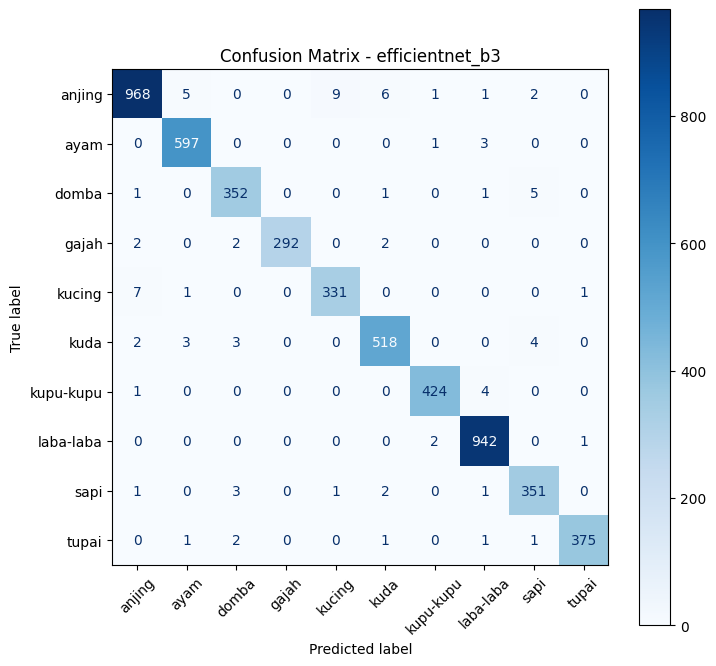

In [16]:
# --- 3. Confusion Matrix ---
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2label[i] for i in range(num_classes)])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)
plt.title(f"Confusion Matrix - {best_backbone}")
plt.savefig("ConfussionMatrix")
plt.show()

Jumlah prediksi BENAR: 5150
Jumlah prediksi SALAH: 85


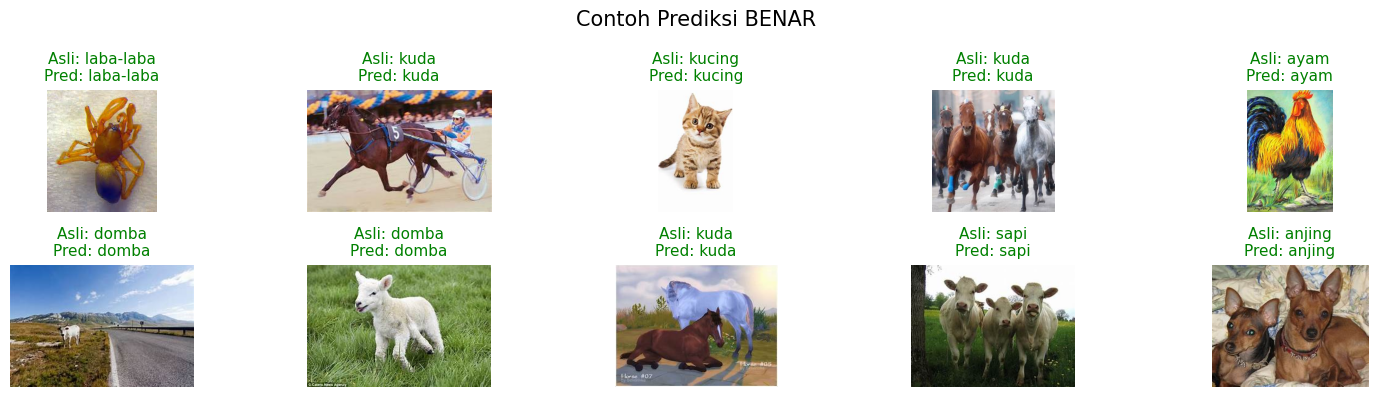

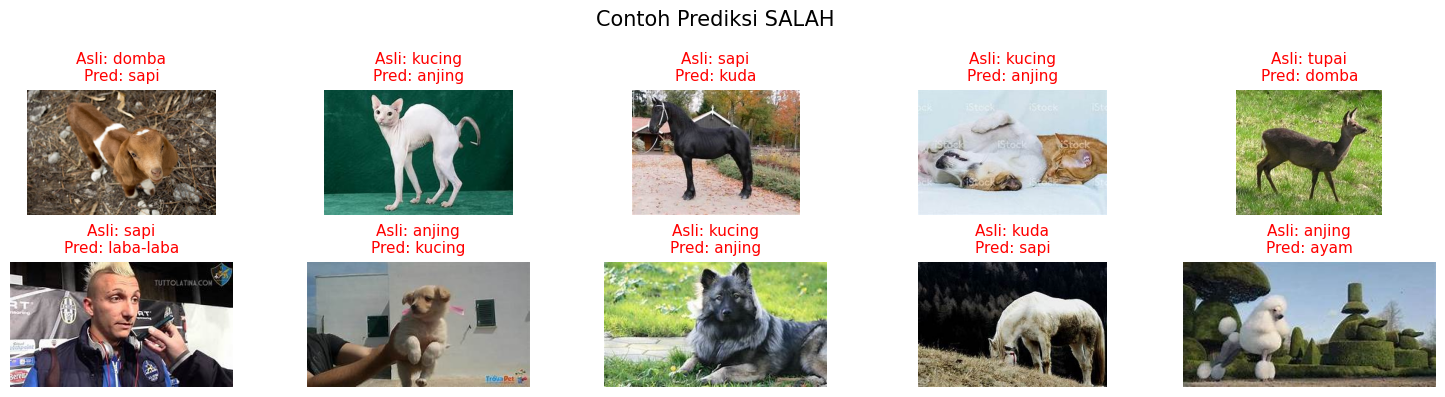

In [17]:

# --- 4. Tampilkan Gambar Prediksi Benar & Salah ---
def show_samples_true(img_paths, true_labels, pred_labels, idx2label, judul, n=10):
    plt.figure(figsize=(3 * 5, 4))
    for i, idx in enumerate(range(min(n, len(img_paths)))):
        img = Image.open(img_paths[idx])
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(
            f"Asli: {idx2label[true_labels[idx]]}\nPred: {idx2label[pred_labels[idx]]}",
            color='green',
            fontsize=11
        )
    plt.suptitle(judul, fontsize=15)
    plt.tight_layout()
    plt.show()

def show_samples_false(img_paths, true_labels, pred_labels, idx2label, judul, n=10):
    plt.figure(figsize=(3 * 5, 4))
    for i, idx in enumerate(range(min(n, len(img_paths)))):
        img = Image.open(img_paths[idx])
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(
            f"Asli: {idx2label[true_labels[idx]]}\nPred: {idx2label[pred_labels[idx]]}",
            color='red',
            fontsize=11
        )
    plt.suptitle(judul, fontsize=15)
    plt.tight_layout()
    plt.show()
    
# Index benar & salah
benar_idx = np.where(preds == labels)[0]
salah_idx = np.where(preds != labels)[0]

print(f"Jumlah prediksi BENAR: {len(benar_idx)}")
print(f"Jumlah prediksi SALAH: {len(salah_idx)}")

# Tampilkan 10 contoh prediksi BENAR
if len(benar_idx) > 0:
    show_samples_true(
        [img_paths[i] for i in benar_idx[:10]],
        [labels[i] for i in benar_idx[:10]],
        [preds[i] for i in benar_idx[:10]],
        idx2label,
        judul="Contoh Prediksi BENAR"
    )

# Tampilkan 10 contoh prediksi SALAH
if len(salah_idx) > 0:
    show_samples_false(
        [img_paths[i] for i in salah_idx[:10]],
        [labels[i] for i in salah_idx[:10]],
        [preds[i] for i in salah_idx[:10]],
        idx2label,
        judul="Contoh Prediksi SALAH"
    )

In [18]:
# --- 5. Simpan Hasil Prediksi ke CSV ---
df_prediksi = pd.DataFrame({
    "img_path": img_paths,
    "true_label": labels,
    "pred_label": preds,
    "true_label_name": [idx2label[l] for l in labels],
    "pred_label_name": [idx2label[p] for p in preds],
    "is_correct": preds == labels
})
# df_prediksi.to_csv("hasil_prediksi_test.csv", index=False)
print("Hasil prediksi test disimpan ke hasil_prediksi_test.csv")

Hasil prediksi test disimpan ke hasil_prediksi_test.csv


In [19]:
import torch
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# --- Ekstrak feature EfficientNet B3 ---
features_hooked = []
def get_features_hook(module, input, output):
    features_hooked.append(output.squeeze(-1).squeeze(-1).detach().cpu())

handle = model.model.avgpool.register_forward_hook(get_features_hook)

labels_all = []
model.eval()
with torch.no_grad():
    for images, labels, *_ in test_loader:
        images = images.to(device)
        _ = model(images)
        labels_all.extend(labels.cpu().numpy())
features = torch.cat(features_hooked, dim=0).numpy()
labels_all = np.array(labels_all)
handle.remove()

# --- Hitung centroid per kelas ---
num_classes = len(idx2label)
centroids = []
for i in range(num_classes):
    class_feats = features[labels_all == i]
    centroid = class_feats.mean(axis=0)
    centroids.append(centroid)
centroids = np.stack(centroids, axis=0)

# --- Clustering dan plot dendrogram ---
Z = linkage(centroids, method='ward')
# plt.figure(figsize=(12, 6))
# dendrogram(
#     Z,
#     labels=[idx2label[i] for i in range(num_classes)],
#     leaf_rotation=90
# )
# plt.title("Visual Similarity Dendrogram (EfficientNet B3 Feature Centroids)")
# plt.tight_layout()
# plt.show()

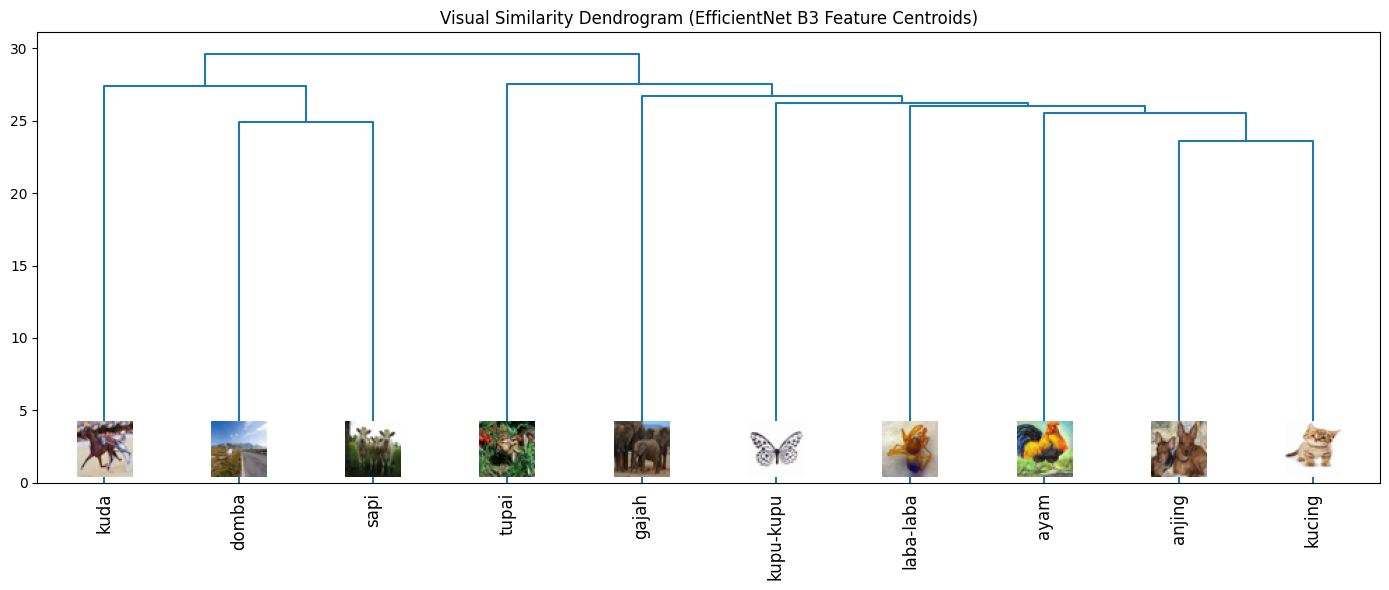

In [20]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from PIL import Image
import matplotlib.offsetbox as offsetbox

def plot_dendrogram_with_images(centroids, class_names, class_img_paths, img_size=40):
    Z = linkage(centroids, method='ward')
    fig, ax = plt.subplots(figsize=(14, 6))
    dendro = dendrogram(Z, labels=class_names, leaf_rotation=90, ax=ax)
    plt.title("Visual Similarity Dendrogram (EfficientNet B3 Feature Centroids)")

    # Ambil posisi x daun
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        class_name = lbl.get_text()
        idx = class_names.index(class_name)
        img_path = class_img_paths[idx]
        img = Image.open(img_path)
        img = img.resize((img_size, img_size))
        imagebox = offsetbox.OffsetImage(img, zoom=1)
        ab = offsetbox.AnnotationBbox(
            imagebox, (lbl.get_position()[0], 0), frameon=False, box_alignment=(0.5, -0.1)
        )
        ax.add_artist(ab)
    plt.tight_layout()
    plt.savefig("Dendogram")
    plt.show()

# --- Contoh penggunaan ---
class_img_paths = []
for i in range(num_classes):
    idx = np.where(labels_all == i)[0][0]  # ambil index pertama kelas i
    class_img_paths.append(img_paths[idx])

plot_dendrogram_with_images(centroids, [idx2label[i] for i in range(num_classes)], class_img_paths)

In [21]:
import time
import torch

# Pastikan class AnimalClassification sudah didefinisikan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(idx2label)  # pastikan idx2label sudah didefinisikan

# Load semua model backbone
model_resnet = AnimalClassification(num_classes=num_classes, backbone="resnet50")
model_resnet.load_state_dict(torch.load("best_model_resnet50.pth", map_location=device))
model_resnet = model_resnet.to(device)

model_efficientnet = AnimalClassification(num_classes=num_classes, backbone="efficientnet_b3")
model_efficientnet.load_state_dict(torch.load("best_model_efficientnet_b3.pth", map_location=device))
model_efficientnet = model_efficientnet.to(device)

model_vgg = AnimalClassification(num_classes=num_classes, backbone="vgg16")
model_vgg.load_state_dict(torch.load("best_model_vgg16.pth", map_location=device))
model_vgg = model_vgg.to(device)

model_vit = AnimalClassification(num_classes=num_classes, backbone="vit_b_16")
model_vit.load_state_dict(torch.load("best_model_vit_b_16.pth", map_location=device))
model_vit = model_vit.to(device)

# Daftar backbone dan modelnya
models_dict = {
    'resnet50': model_resnet,
    'efficientnet_b3': model_efficientnet,
    'vgg16': model_vgg,
    'vit_b_16': model_vit
}

# Ambil satu batch dari test_loader
images, labels, *_ = next(iter(test_loader))
image = images[0].unsqueeze(0).to(device)  # satu gambar

inference_times = {}

for name, model in models_dict.items():
    model.eval()
    with torch.no_grad():
        # Warmup (opsional, untuk GPU)
        for _ in range(5):
            _ = model(image)
        # Sinkronisasi untuk GPU
        if device.type == 'cuda':
            torch.cuda.synchronize()
        start = time.time()
        _ = model(image)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        end = time.time()
        inf_time_ms = (end - start) * 1000
        inference_times[name] = inf_time_ms
        print(f"Inference time untuk 1 gambar ({name}): {inf_time_ms:.2f} ms")

Inference time untuk 1 gambar (resnet50): 7.00 ms
Inference time untuk 1 gambar (efficientnet_b3): 12.58 ms
Inference time untuk 1 gambar (vgg16): 5.18 ms
Inference time untuk 1 gambar (vit_b_16): 10.72 ms


In [22]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.5 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=556c7a8d260e5dcd54dac51c44ca15bdbadc0605da930eefab1da81e32e5ea3f
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f4

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision import transforms

def get_img_array(img_path, size=(224, 224)):
    img = Image.open(img_path).convert("RGB")
    img = img.resize(size)
    img_np = np.array(img).astype(np.float32) / 255.0
    return img, img_np

def make_gradcam_heatmap(model, img_path, target_layers, preprocess, device, class_idx=None):
    img, img_np = get_img_array(img_path, size=(224, 224))
    input_tensor = preprocess(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        if class_idx is None:
            class_idx = outputs.argmax(dim=1).item()
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(class_idx)])
    heatmap = grayscale_cam[0]
    return img_np, heatmap, class_idx

def save_and_display_gradcam(img_path, heatmap, img_np, cam_path="save_cam_image.jpg", alpha=0.4):
    # Rescale heatmap to 0-255
    heatmap_uint8 = np.uint8(255 * heatmap)
    # Colorize heatmap
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_uint8]
    jet_heatmap = Image.fromarray((jet_heatmap * 255).astype(np.uint8))
    jet_heatmap = jet_heatmap.resize((img_np.shape[1], img_np.shape[0]))
    jet_heatmap = np.array(jet_heatmap).astype(np.float32) / 255.0

    # Superimpose
    superimposed_img = jet_heatmap * alpha + img_np * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 1)

    # Save
    plt.imsave(cam_path, superimposed_img)
    # Display
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM Overlay")
    plt.show()

# --- Contoh penggunaan untuk EfficientNet B3 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_efficientnet.to(device)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
target_layers = [model.model.features[-1]]

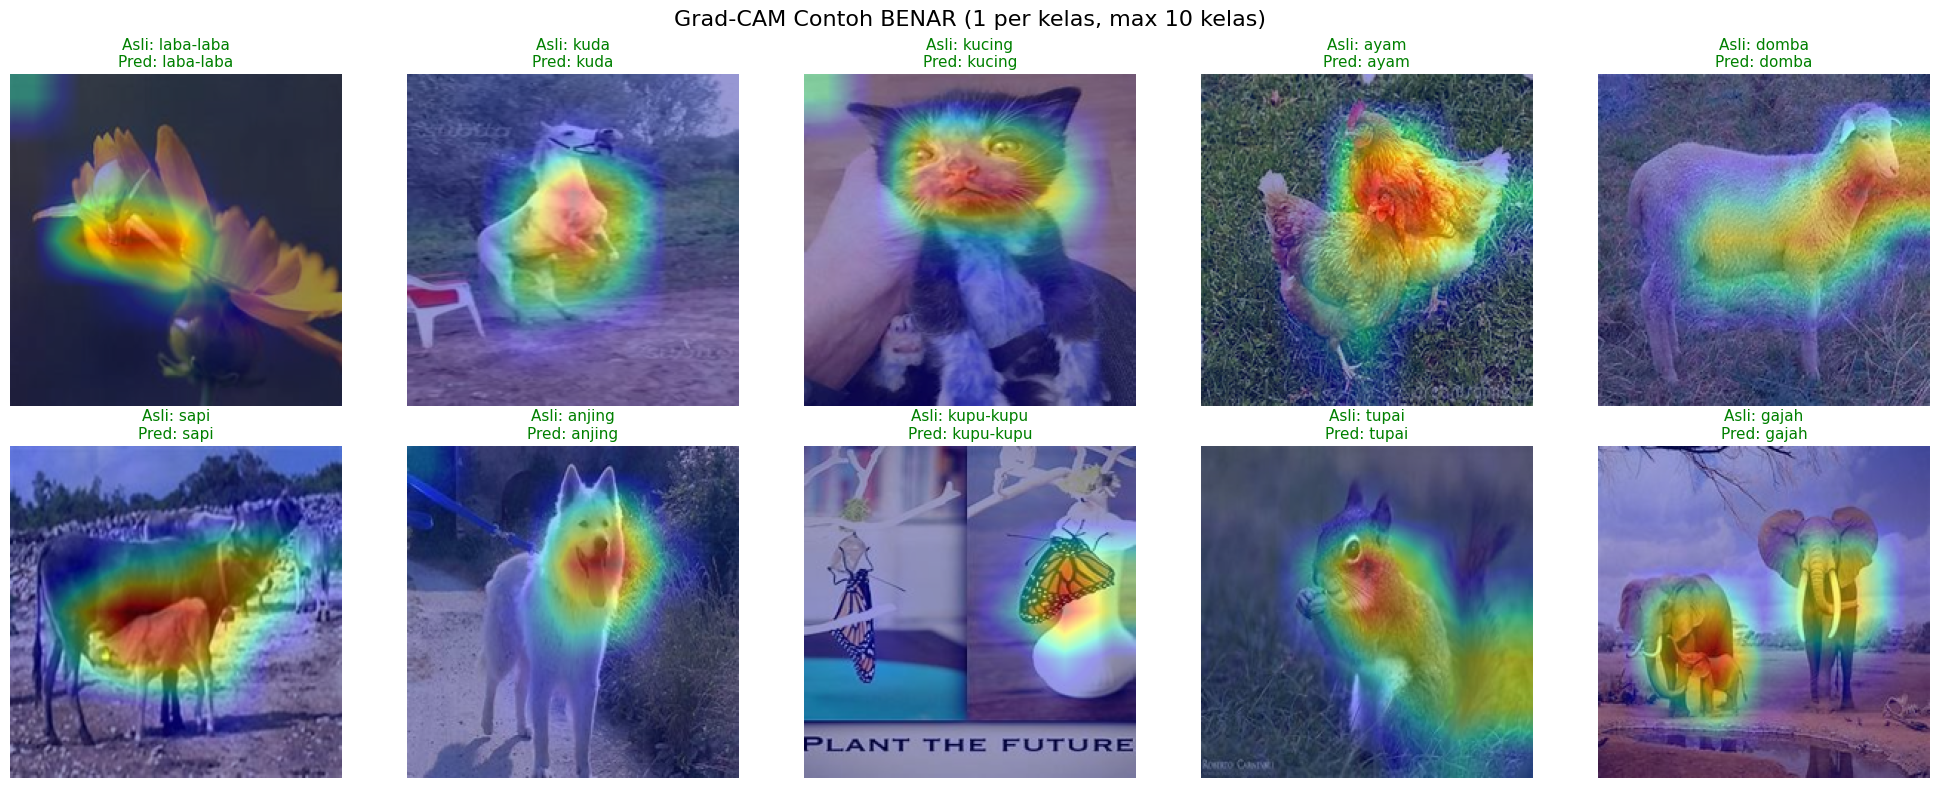

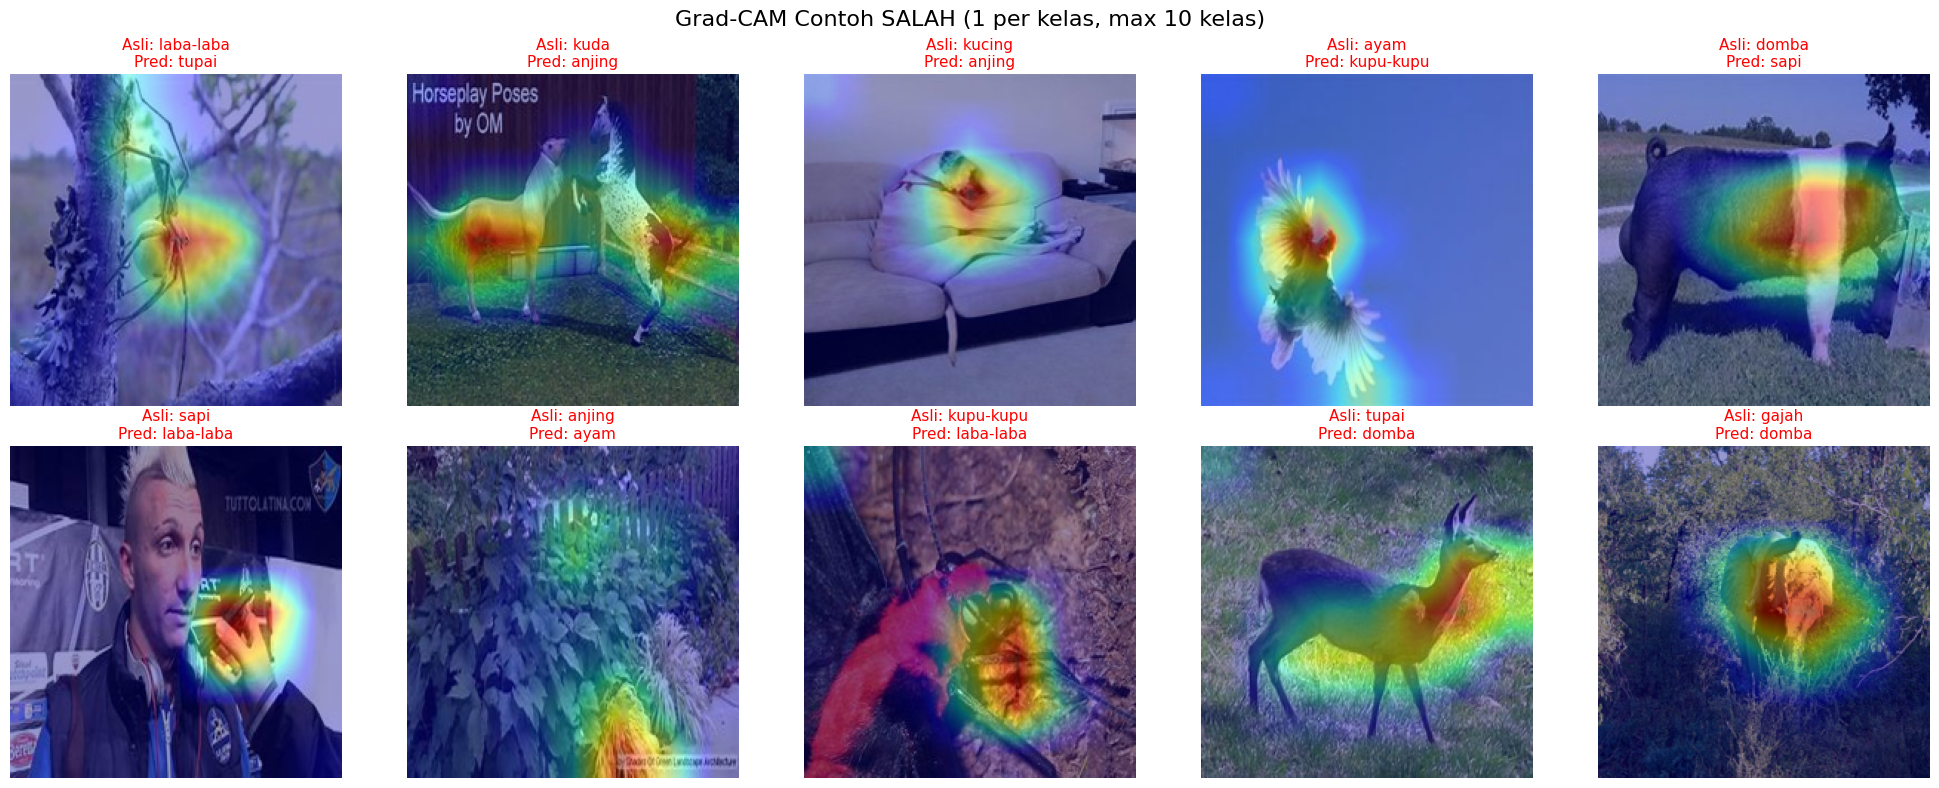

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def gradcam_overlay(img_path, model, target_layers, preprocess, device, pred_class):
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img.resize((224, 224))).astype(np.float32) / 255.0
    input_tensor = preprocess(img).unsqueeze(0).to(device)
    model.eval()
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])
    heatmap = grayscale_cam[0]
    # Overlay
    heatmap_uint8 = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_uint8]
    jet_heatmap = Image.fromarray((jet_heatmap * 255).astype(np.uint8))
    jet_heatmap = jet_heatmap.resize((img_np.shape[1], img_np.shape[0]))
    jet_heatmap = np.array(jet_heatmap).astype(np.float32) / 255.0
    superimposed_img = jet_heatmap * 0.4 + img_np * 0.6
    superimposed_img = np.clip(superimposed_img, 0, 1)
    return superimposed_img

def plot_gradcam_from_df(df_prediksi, model, target_layers, preprocess, device, mode='benar', n_class=10):
    # mode: 'benar' atau 'salah'
    class_names = df_prediksi['true_label_name'].unique()[:n_class]
    n_cols = 5
    n_rows = 2
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
    axs = axs.flatten()
    count = 0
    for class_name in class_names:
        if mode == 'benar':
            df_sample = df_prediksi[(df_prediksi['true_label_name'] == class_name) & (df_prediksi['is_correct'])]
        else:
            df_sample = df_prediksi[(df_prediksi['true_label_name'] == class_name) & (~df_prediksi['is_correct'])]
        if not df_sample.empty and count < n_cols * n_rows:
            row = df_sample.sample(1, random_state=42).iloc[0]
            overlay = gradcam_overlay(
                row['img_path'], model, target_layers, preprocess, device, row['pred_label']
            )
            axs[count].imshow(overlay)
            axs[count].set_title(
                f"Asli: {row['true_label_name']}\nPred: {row['pred_label_name']}",
                color='green' if mode == 'benar' else 'red', fontsize=11
            )
            axs[count].axis('off')
            count += 1
    # Kosongkan subplot sisa
    for i in range(count, n_cols * n_rows):
        axs[i].axis('off')
    plt.suptitle(f"Grad-CAM Contoh {'BENAR' if mode == 'benar' else 'SALAH'} (1 per kelas, max 10 kelas)", fontsize=16)
    plt.tight_layout()
    plt.show()

# --- Contoh penggunaan ---
# Plot benar
plot_gradcam_from_df(df_prediksi, model, target_layers, preprocess, device, mode='benar', n_class=10)

# Plot salah
plot_gradcam_from_df(df_prediksi, model, target_layers, preprocess, device, mode='salah', n_class=10)